# Data preprocessing

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from google_drive_downloader import GoogleDriveDownloader as gdd

%matplotlib inline

I used astrology "predictions" from the corresponding [vk community](https://vk.com/gachiastro) as a dataset.

In [ ]:
gachi_dataset = '1AGa8iBzyBDSRaLvk88YyJ1qeIIVQaO0k'
gdd.download_file_from_google_drive(file_id=gachi_dataset, dest_path='./gachi_astro.txt')

In [ ]:
with open('gachi_astro.txt', encoding="utf8") as file_data:
    gachi_data = file_data.readlines()

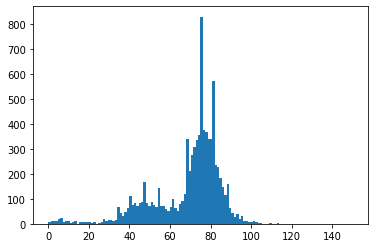

In [ ]:
plt.hist([len(t.split()) for t in gachi_data], bins=128, range=(0, 150))
plt.show()

In [ ]:
print(min(map(lambda x: len(x), filter(lambda x: 30 < len(x.split()) < 63, gachi_data))))
print(max(map(lambda x: len(x), filter(lambda x: 30 < len(x.split()) < 63, gachi_data))))

182
506


In [ ]:
corpus = gachi_data
print(len(corpus))

8584


## Tokenization

Tokenizer lefts only correct characters in processing sentences and trims multiple spaces to a single one.

In [ ]:
class Tokenizer:
    def __init__(self):
        self.regex = r"([^a-zA-Zа-яА-Я0-9\.\,\!\?\;\:\&\-\"\'\` ])"

    def tokenize(self, sentence: str):
        cleaned = re.sub(self.regex, "", sentence)
        trimmed_spaces = re.sub(r"[ ]+", " ", cleaned)
        last_dot_index = trimmed_spaces.find('.')
        if last_dot_index > 0:
            return trimmed_spaces[:last_dot_index + 1]
        return trimmed_spaces

## Build vocab

Vocab contains digits, russian and english alphabets in lower and upper cases and some special characters. Also it can parse incoming sentences and retrieve ngramms using settings passed in the constructor.

I know that the tokenization could be made using Aho-Corasik automaton, but I wanted to finish the notebook ASAP.

In [ ]:
class Vocab:
    START_TOKEN = '<sos>'
    END_TOKEN = '<eos>'
    PADDING_TOKEN = '<pad>'
    def __init__(self, text_data, ngramm_params):
        # init tokenizer and char2idx/idx2char maps
        self.tokenizer = Tokenizer()
        self.char2idx = {
            Vocab.START_TOKEN: 0,
            Vocab.END_TOKEN: 1,
            Vocab.PADDING_TOKEN: 2
        }
        self.idx2char = {
            0: Vocab.START_TOKEN,
            1: Vocab.END_TOKEN,
            2: Vocab.PADDING_TOKEN
        }
        # build vocab sources
        digits = '0123456789'
        eng_alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        rus_alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
        extra_chars = '.,!?;:&-"\'` '
        alphabet = digits + eng_alphabet + rus_alphabet + extra_chars
        self.__add_to_dict__(alphabet)
        self.__add_ngramms__(text_data, ngramm_params)
        
    def __add_ngramms__(self, text_data, ngramm_params):
        self.ngramms = {}
        self.__max_ngramm = 0
        for (n, topk) in ngramm_params:
            if n < 2:
                print('Warn: ngramms with n < 2 are not considered')
                continue
            self.__max_ngramm = max(self.__max_ngramm, n)
            self.ngramms[n] = self.__get_ngramms__(text_data, n, topk)
            self.__add_to_dict__(self.ngramms[n])

    def __add_to_dict__(self, sequence):
        padding = len(self.char2idx)
        for i, item in enumerate(sequence):
            self.char2idx[item] = i + padding
            self.idx2char[i + padding] = item
        assert len(self.char2idx) == len(self.idx2char)

    def __get_ngramms__(self, data, n, topk):
        cnt = {}
        for item in data:
            l = len(item)
            for i in range(l - n + 1):
                ngramm = item[i:i + n]
                # how to validate properly?
                if ' ' in ngramm or '.' in ngramm or ',' in ngramm:
                    continue
                if ngramm not in cnt.keys():
                    cnt[ngramm] = 0
                cnt[ngramm] += 1
        joint_ngramms = map(lambda x: (x, cnt[x]), cnt)
        sorted_ngramms = list(map(lambda x: x[0], sorted(joint_ngramms, key=lambda x: -x[1])))
        return set(sorted_ngramms[:topk])

    def tokenize(self, sequence):
        sequence = self.tokenizer.tokenize(sequence)
        tokens = []
        i, n = 0, len(sequence)
        while i < n:
            ngramm_added = False
            for k in range(self.__max_ngramm, 1, -1):
                if not k in self.ngramms.keys():
                    continue
                if i < n - k + 1 and sequence[i:i + k] in self.ngramms[k]:
                    tokens.append(self.char2idx[sequence[i:i + k]])
                    ngramm_added = True
                    i += k
                    break
            if not ngramm_added:
                tokens.append(self.char2idx[sequence[i]])
                i += 1
        return tokens

    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence.numpy()])
    
    def __len__(self):
        return len(self.char2idx)

## Define text dataset

In [ ]:
class TextDataset():
    def __init__(self, records, min_words=16, max_words=32, max_chars=256, ngramm_params=[]):
        if ngramm_params is None:
            ngramm_params = []
        filtered_records = filter(lambda r: min_words <= len(r.split()) <= max_words, records)
        truncated_records = map(lambda s: s[:self.__last_dot_position__(s, max_chars)], filtered_records)
        data = list(truncated_records)
        self.vocab = Vocab(data, ngramm_params)
        self.min_len = min_words
        self.max_len = max_chars
        self.data = data

    def __last_dot_position__(self, s, max_len):
        truncated_positions = [i for (i, c) in enumerate(s) if c == '.' and i < max_len - 2]
        return min(len(s), max_len - 2) if len(truncated_positions) == 0 else truncated_positions[-1] + 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        max_len = self.max_len
        start_token = self.vocab.char2idx[Vocab.START_TOKEN]
        padding_token = self.vocab.char2idx[Vocab.PADDING_TOKEN]
        end_token = self.vocab.char2idx[Vocab.END_TOKEN]
        # add paddings
        sample = self.vocab.tokenize(self.data[idx])
        sample_len = len(sample)
        token_sample = [start_token] + sample + [end_token] + [padding_token] * (max_len - sample_len - 2)
        try:
            assert len(token_sample) == max_len
        except:
            print(idx, len(token_sample), token_sample)
            raise RuntimeError
        # convert to tensors
        sample = torch.LongTensor(token_sample)
        target = torch.LongTensor(token_sample[1:] + [padding_token])
        return sample, target

In [ ]:
dataset = TextDataset(corpus, 32, 128, 512, [(2, 10), (3, 10)])

In [ ]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu') # for debugging purposes

# Model

This class defines the language model. It uses standard PyTorch embedding layer, gated recurrent unit and does not use weights tying.

`init_hidden` method should be marked with `@torch.jit.export` annotation for model to be properly serialized using torchscript.

## Define LM

In [ ]:
class LM(nn.Module):
    def __init__(self, batch_size, vocab_size, hidden_dim, num_layers, dropout):
        super().__init__()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.Sequential(
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Linear(hidden_dim // 2, vocab_size)
        )
        self.softmax = nn.LogSoftmax(1)

    def forward(self, input, hidden, temperature: float = 1.0):
        emb = F.gelu(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        reshaped_output = output.reshape(output.size(0) * output.size(1), output.size(2))
        decoded = self.decoder(reshaped_output)
        scaled_decoded = decoded / temperature
        result = self.softmax(scaled_decoded).view(output.size(0), output.size(1), decoded.size(1))

        return result, hidden

    def init_hidden(self, batch_size):
        return torch.ones(self.num_layers, batch_size, self.hidden_dim)

In [ ]:
epochs = 8
lr = 1e-3
batch_size = 64

In [ ]:
model = LM(
    batch_size = batch_size,
    vocab_size = len(dataset.vocab),
    hidden_dim = 256,
    num_layers = 4,
    dropout = 0.01
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss(ignore_index=2) # ignore padding token

In [ ]:
train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test = DataLoader(test_set, batch_size=batch_size)

In [ ]:
train_history = []
test_history = []

## Train LM

  0%|          | 0/117 [00:00<?, ?it/s]

epoch: 0, train loss: 2.720098877564454, test loss: 1.7761746828372664


  0%|          | 0/117 [00:00<?, ?it/s]

epoch: 1, train loss: 1.455439898702833, test loss: 1.3171901244383595


  0%|          | 0/117 [00:00<?, ?it/s]

epoch: 2, train loss: 1.1891906816735227, test loss: 1.1660131216049194


  0%|          | 0/117 [00:00<?, ?it/s]

epoch: 3, train loss: 1.0659115069951766, test loss: 1.0657077110730686


  0%|          | 0/117 [00:00<?, ?it/s]

epoch: 4, train loss: 0.9796422185041966, test loss: 1.0091185844861543


  0%|          | 0/117 [00:00<?, ?it/s]

epoch: 5, train loss: 0.9128677355937469, test loss: 0.9752614589837882


  0%|          | 0/117 [00:00<?, ?it/s]

epoch: 6, train loss: 0.8594413715550023, test loss: 0.9467744781420782


100%|██████████| 13/13 [00:00<00:00, 16.04it/s]


epoch: 7, train loss: 0.8131112339150192, test loss: 0.928102135658264


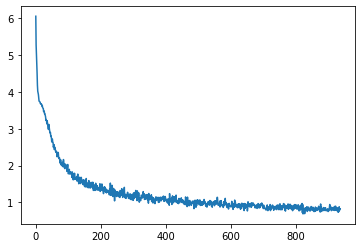

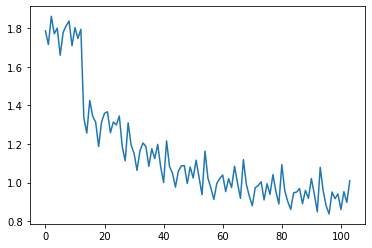

In [ ]:
try:
    for e in range(epochs):
        avg_train_loss = 0
        avg_test_loss = 0
        model.train()
        for x, y in tqdm(train, position=0, leave=True):
            model.zero_grad()
            hidden = model.init_hidden(len(x)).to(device)
            x, y = x.to(device), y.to(device)
            output, _ = model(x, hidden)
            loss = criterion(output.permute(0, 2, 1), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.8)
            train_history.append(loss.item())
            avg_train_loss += loss.item() / len(train)

            optimizer.step()
            del x
            del y
            del hidden
            torch.cuda.empty_cache()
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(test, position=0, leave=True):
                hidden = model.init_hidden(len(x)).to(device)
                x, y = x.to(device), y.to(device)
                output, _ = model(x, hidden)
                loss = criterion(output.permute(0, 2, 1), y)
                test_history.append(loss.item())
                avg_test_loss += loss.item() / len(test)
                del x
                del y
                del hidden
                torch.cuda.empty_cache()
        print(f'epoch: {e}, train loss: {avg_train_loss}, test loss: {avg_test_loss}')
except KeyboardInterrupt:
    print('Manual stop')

plt.plot(train_history)
plt.show()
plt.plot(test_history)
plt.show()

# Texts generation

## Define sampling method

In [ ]:
def sample(model, vocab: Vocab, num_tokens, seed="", temperature=1.0):
    model.eval()
    input_encoded = vocab.tokenize(seed)
    result = ''
    hidden = model.init_hidden(1).to(device)
    input_var = Variable(torch.LongTensor([input_encoded]))

    with torch.no_grad():
        while input_encoded[0] != vocab.char2idx['<eos>']:
            output, hidden = model(input_var.to(device), hidden, temperature)
            a = output.cpu().data[0, -1, :].numpy()
            p = np.exp(a) / np.exp(a).sum()
            input_encoded = [np.random.choice(len(vocab), p=p)]
            result += vocab.idx2char[input_encoded[0]]
            if len(result) > num_tokens:
                break
            input_var = Variable(torch.LongTensor(input_encoded)).view(1, 1)
    return result

## Experiments!

In [ ]:
signs = [
    'Овен',
    'Телец',
    'Близнецы',
    'Рак',
    'Лев',
    'Дева',
    'Весы',
    'Скорпион',
    'Стрелец',
    'Козерог',
    'Водолей',
    'Рыбы'
]

In [ ]:
for sign in signs:
    beginning = f'{sign}, 30 апреля:'
    print(f'{beginning}{sample(model, dataset.vocab, 512, beginning, .3)}')
    print()

Овен, 30 апреля: вы не откладываете на потом.<eos>

Телец, 30 апреля: вы сможете добиться отличных результатов в качалке.<eos>

Близнецы, 30 апреля: вы сможете сделать много semen, чем обычно.<eos>

Рак, 30 апреля: вы сможете отдохнуть в себе проблемы, которые не даже с которыми вы не станете перед собой, и добьетесь отличных результатов в качалке.<eos>

Лев, 30 апреля: вы сможете сделать много полезного и не давали вам позже вас в последнее время.<eos>

Дева, 30 апреля: вы сможете добиться отличных оргиях, но вы сможете сделать много позициально самых разных ass.<eos>

Весы, 30 апреля: вы сможете сделать много полезного и не откладывать на потом.<eos>

Скорпион, 30 апреля: вы не станете спешить с самого утра.<eos>

Стрелец, 30 апреля: вам не откажетесь от того, что беретесь.<eos>

Козерог, 30 апреля: вы сможете проявить настойчивы, особенно добиться отличных результатов в качалке.<eos>

Водолей, 30 апреля: вы сосредоточиться на первый взгляд.<eos>

Рыбы, 30 апреля: в этом время не все